In [5]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [6]:
from STalign import STalign

In [7]:
# Single cell data 1
# read in data
fname = 'Xenium/outs/cells.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

   cell_id  x_centroid  y_centroid  transcript_counts  control_probe_counts  \
0        1  847.259912  326.191365                 28                     1   
1        2  826.341995  328.031830                 94                     0   
2        3  848.766919  331.743187                  9                     0   
3        4  824.228409  334.252643                 11                     0   
4        5  841.357538  332.242505                 48                     0   

   control_codeword_counts  total_counts   cell_area  nucleus_area  
0                        0            29   58.387031     26.642187  
1                        0            94  197.016719     42.130781  
2                        0             9   16.256250     12.688906  
3                        0            11   42.311406     10.069844  
4                        0            48  107.652500     37.479687  


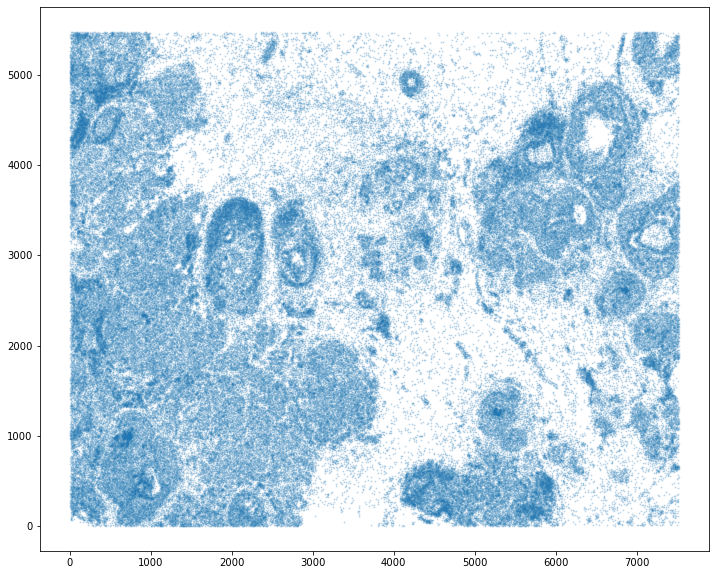

In [8]:
# get cell centroid coordinates
xI = np.array(df1['x_centroid'])
yI = np.array(df1['y_centroid'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)
#ax.set_aspect('equal', 'box')

0 of 167780
10000 of 167780
20000 of 167780
30000 of 167780
40000 of 167780
50000 of 167780
60000 of 167780
70000 of 167780
80000 of 167780
90000 of 167780
100000 of 167780
110000 of 167780
120000 of 167780
130000 of 167780
140000 of 167780
150000 of 167780
160000 of 167780
167779 of 167780


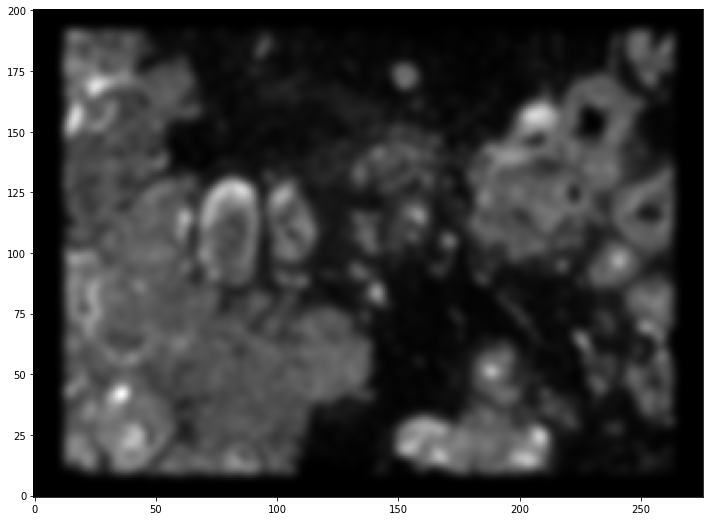

In [9]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI, yI, dx=30)

ax = fig.axes[0]
ax.invert_yaxis()

In [10]:
print("The initial shape of I is {}".format(I.shape))
I = np.vstack((I, I, I)) # make into 3xNxM
print("The range of I is {} to {}".format(I.min(), I.max() ))

# normalize
I = STalign.normalize(I)
print("The range of I after normalization is {} to {}".format(I.min(), I.max() ))


The initial shape of I is (1, 201, 276)
The range of I is 0.0 to 16.12606396261136
The range of I after normalization is 0.0 to 1.0


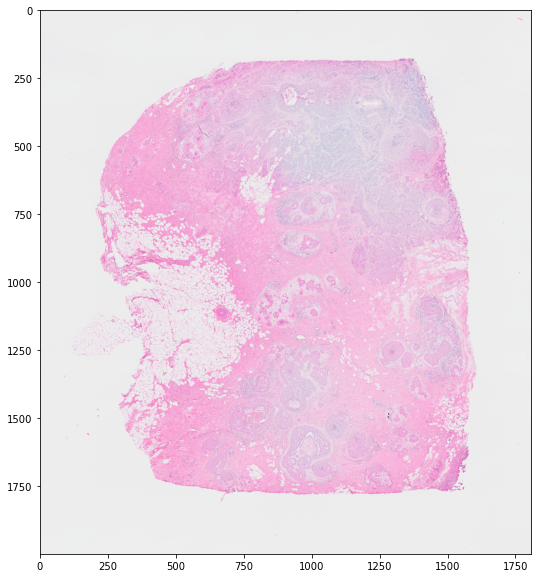

In [11]:
image_file = 'Visium/spatial/tissue_hires_image.png'
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

In [12]:
print("The initial shape of V is {}".format(V.shape))
print("The range of V is {} to {}".format(V.min(), V.max() ))

Vnorm = STalign.normalize(V)
print("The range of V after normalization is {} to {}".format(Vnorm.min(), Vnorm.max() ))

The initial shape of V is (2000, 1809, 3)
The range of V is 0.027450980618596077 to 0.9921568632125854
The range of V after normalization is 0.0 to 1.0


In [13]:
J = Vnorm.transpose(2,0,1)
print("The new shape of J is {}".format(J.shape))

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.


The new shape of J is (3, 2000, 1809)


Text(0.5, 1.0, 'target')

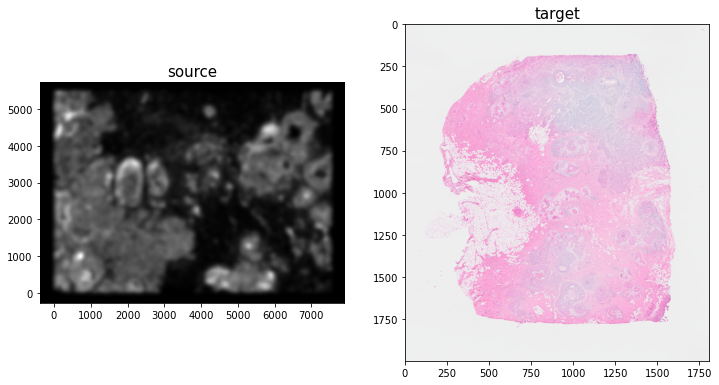

In [14]:
# plot

# get extent of images
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI)
ax[0].invert_yaxis()
ax[0].set_title('source', fontsize=15)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)
ax[1].set_title('target', fontsize=15)


In [15]:
np.savez('xenium', x=XI,y=YI,I=I)
np.savez('visium', x=XJ,y=YJ,I=J)

In [17]:
# read from file
pointsIlist = np.load('xenium_points.npy', allow_pickle=True).tolist()
print(pointsIlist)
pointsJlist = np.load('visium_points.npy', allow_pickle=True).tolist()
print(pointsJlist)

{'duct1': [(2030.0912502541082, 3070.396401257639)], 'duct2': [(5271.755766383141, 1307.5576915802194)], 'duct3': [(6544.917056705723, 4402.3189819028)]}
{'duct1': [(991.1432258064515, 734.1800000000003)], 'duct2': [(1299.2567741935482, 1258.4009677419356)], 'duct3': [(794.2929032258066, 1504.4638709677422)]}


In [18]:
# convert to array
pointsI = []
pointsJ = []

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])

pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

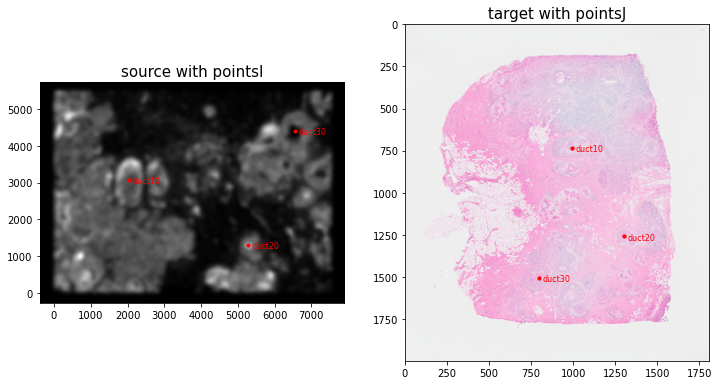

In [19]:
# plot

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)

ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

# invert only rasterized image
ax[0].invert_yaxis()

In [20]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [21]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI,pointsJ)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

/Users/jeanfan/mambaforge/envs/pytorch_m1/lib/python3.9/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Text(0.5, 1.0, 'target')

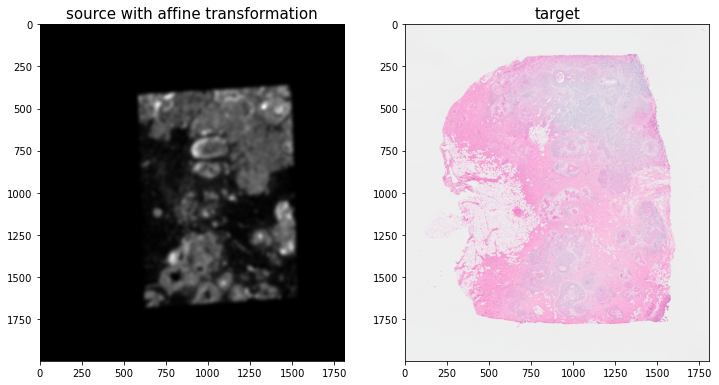

In [22]:
# compute initial affine transformation from points
AI= STalign.transform_image_source_with_A(A, [YI,XI], I, [YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if AI.is_cuda:
    AI = AI.cpu()

fig,ax = plt.subplots(1,2)

ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extentJ)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

Text(0.5, 1.0, 'Landmark-based Affine Alignment')

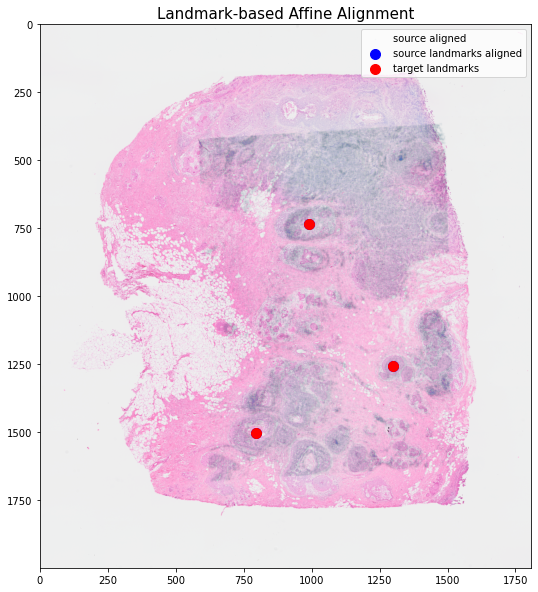

In [26]:
#apply A to sources points in row, column (y,x) orientation
affine = np.matmul(np.array(A.cpu()),np.array([yI, xI, np.ones(len(xI))]))

xIaffine = affine[1,:]
yIaffine = affine[0,:]


#apply A to sources landmark points in row, column (y,x) orientation
ypointsI = pointsI[:,0]
xpointsI = pointsI[:,1]
affine = np.matmul(np.array(A.cpu()),np.array([ypointsI, xpointsI, np.ones(len(ypointsI))]))

xpointsIaffine = affine[1,:]
ypointsIaffine = affine[0,:]
pointsIaffine = np.column_stack((ypointsIaffine,xpointsIaffine))


# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

ax.scatter(xIaffine,yIaffine,s=1,alpha=0.01, label = 'source aligned')
ax.scatter(pointsIaffine[:,1],pointsIaffine[:,0],c="blue", label='source landmarks aligned', s=100)

ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=100)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)

ax.set_title('Landmark-based Affine Alignment', fontsize=15)

CPU times: user 20min 57s, sys: 11min, total: 31min 57s
Wall time: 14min 7s


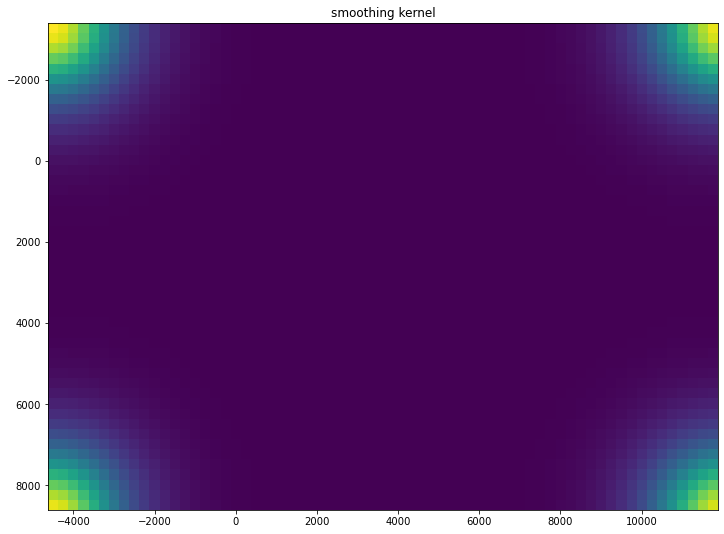

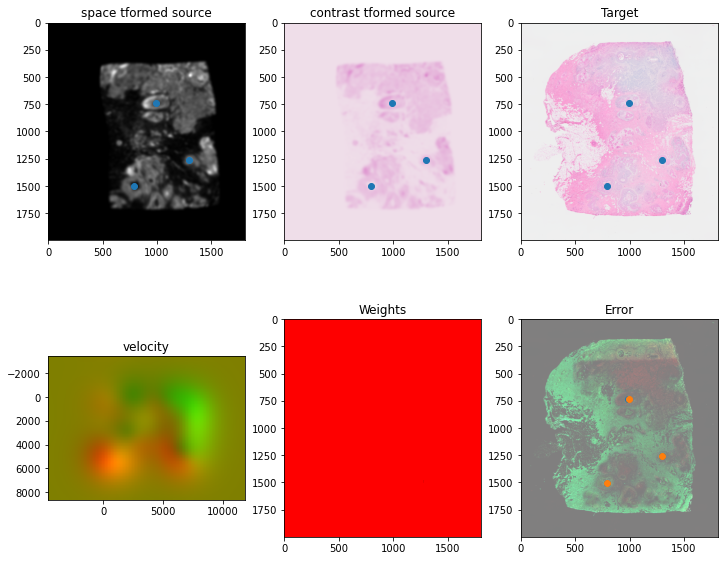

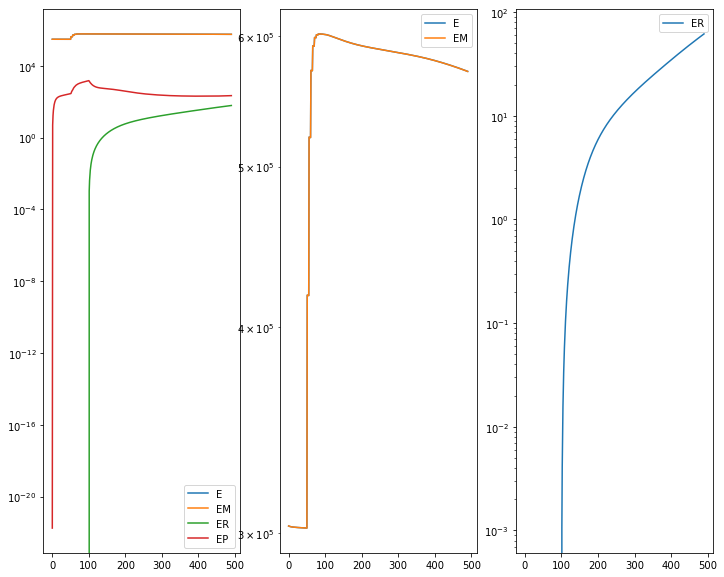

In [39]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {'L':L,'T':T,
          'niter': 500,
          'pointsI': pointsI,
          'pointsJ': pointsJ,
          'device': device,
          'sigmaP': 2e-1,
          'sigmaM': 0.2,
          'sigmaB': 0.3,
          'sigmaA': 0.3,
          'diffeo_start' : 100,
          'epL': 5e-11,
          'epT': 5e-4,
          'epV': 5e1
          }

out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [40]:
#### get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']
WM = out['WM']

In [41]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phiipointsI = STalign.transform_points_source_to_target(xv,v,A,pointsI)

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()
if phiipointsI.is_cuda:
    phiipointsI = phiipointsI.cpu()



In [42]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

Text(0.5, 1.0, 'After alignment aligned source and target with aligned pointsI and pointsJ')

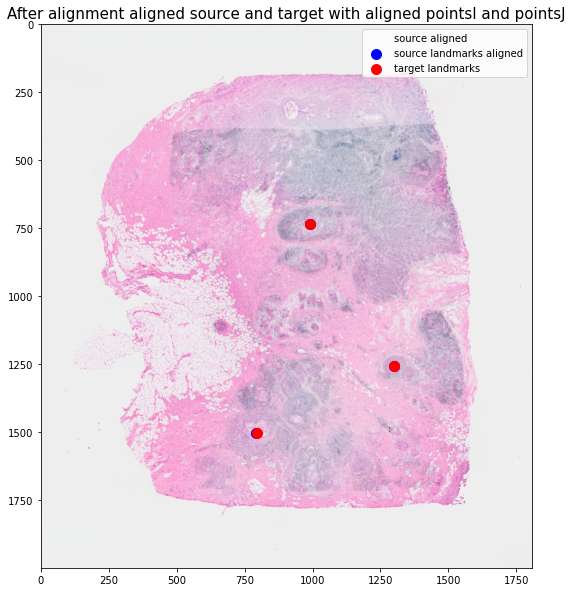

In [43]:
# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.01, label = 'source aligned')
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="blue", label='source landmarks aligned', s=100)

ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=100)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)

ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ', fontsize=15)


In [53]:
if tpointsI.is_cuda:
    df3 = pd.DataFrame(

        {

            "aligned_x": xI_LDDMM.cpu(),

            "aligned_y": yI_LDDMM.cpu(),

        },


    )
else:
    df3 = pd.DataFrame(

        {

            "aligned_x": xI_LDDMM,

            "aligned_y": yI_LDDMM,

        },


    )
results = pd.concat([df1, df3], axis=1)
results.head()

cell_id  x_centroid  y_centroid  transcript_counts  control_probe_counts  \
0        1  847.259912  326.191365                 28                     1   
1        2  826.341995  328.031830                 94                     0   
2        3  848.766919  331.743187                  9                     0   
3        4  824.228409  334.252643                 11                     0   
4        5  841.357538  332.242505                 48                     0   

   control_codeword_counts  total_counts   cell_area  nucleus_area  \
0                        0            29   58.387031     26.642187   
1                        0            94  197.016719     42.130781   
2                        0             9   16.256250     12.688906   
3                        0            11   42.311406     10.069844   
4                        0            48  107.652500     37.479687   

     aligned_x   aligned_y  
0  1423.756399  509.142690  
1  1422.803699  505.648184  
2  1422.816935  509.421795  
3  1421.638695  505.324212  
4  1422.506788  508.183279

In [54]:
results.to_csv('xenium_to_visium_stalign.csv.gz', 
                compression='gzip')

In [55]:
# Spot data
# read in data
fname = 'Visium/spatial/tissue_positions.csv'
df4 = pd.read_csv(fname)
print(df4.head())

              barcode  in_tissue  array_row  array_col  pxl_row_in_fullres  \
0  GTCACTTCCTTCTAGA-1          1          0          0                4550   
1  CACGGTCTCCTTACGA-1          1          0          2                4552   
2  ATAGCTGCGGATAAGA-1          1          0          4                4553   
3  GTCAGTATGTCCGGCG-1          1          0          6                4554   
4  ATGTACCAGTTACTCG-1          1          0          8                4556   

   pxl_col_in_fullres  
0               15271  
1               15088  
2               14905  
3               14723  
4               14540  


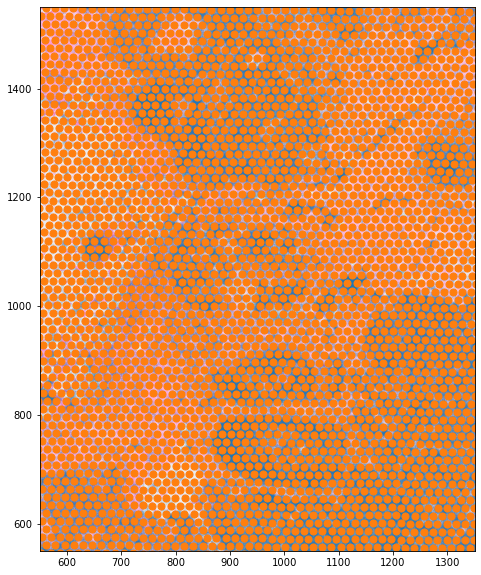

In [72]:
# plot
fig,ax = plt.subplots()
ax.set(xlim=(550, 1350), ylim=(550, 1550))

ax.imshow(V)

ax.scatter(results['aligned_x'],results['aligned_y'],s=10,alpha=0.1,vmin=0,vmax=1)
ax.scatter(df4['pxl_col_in_fullres']*0.092717074,df4['pxl_row_in_fullres']*0.092717074,s=50,vmin=0,vmax=1)


In [93]:
vi = (results['aligned_x'] > 550) & (results['aligned_x']< 1350) & (results['aligned_y'] > 550) & (results['aligned_y'] < 1550)
resultsSub = results[vi]

In [94]:
vi = (df4['pxl_col_in_fullres']*0.092717074 > 550) & (df4['pxl_col_in_fullres']*0.092717074 < 1350) & (df4['pxl_row_in_fullres']*0.092717074 > 550) & (df4['pxl_row_in_fullres']*0.092717074 < 1550)
spotsSub = df4[vi]

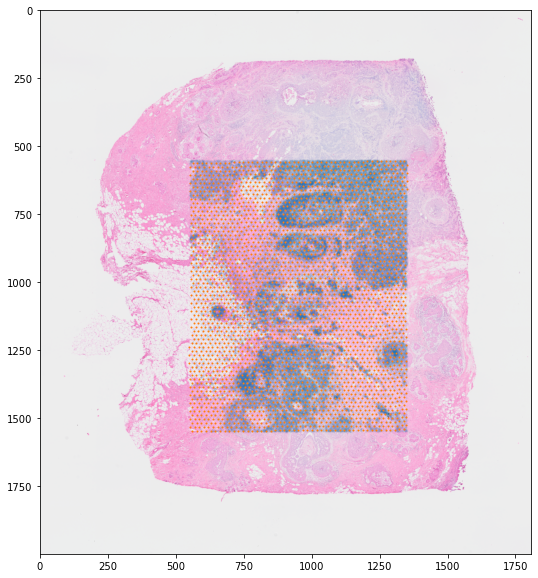

In [96]:
# plot
fig,ax = plt.subplots()
ax.imshow(V)

ax.scatter(resultsSub['aligned_x'],resultsSub['aligned_y'],s=1,alpha=0.05,vmin=0,vmax=1)
ax.scatter(spotsSub['pxl_col_in_fullres']*0.092717074,spotsSub['pxl_row_in_fullres']*0.092717074,s=1,vmin=0,vmax=1)


In [99]:
spotsSub['aligned_x'] = spotsSub['pxl_col_in_fullres']*0.092717074
spotsSub['aligned_y'] = spotsSub['pxl_row_in_fullres']*0.092717074
spotsSub


/var/folders/h6/yrnr80p14tdb_rr5pln6lg_00000gn/T/ipykernel_1691/1278240274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotsSub['aligned_x'] = spotsSub['pxl_col_in_fullres']*0.092717074
/var/folders/h6/yrnr80p14tdb_rr5pln6lg_00000gn/T/ipykernel_1691/1278240274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotsSub['aligned_y'] = spotsSub['pxl_row_in_fullres']*0.092717074


barcode  in_tissue  array_row  array_col  pxl_row_in_fullres  \
580   ACTGCAAGGCTTCTCG-1          1          9          9                5986   
581   TGGTGCGAATCCTGCT-1          1          9         11                5988   
582   CTTCGAGTGATGGAAT-1          1          9         13                5989   
583   TACTCACTACTCACTC-1          1          9         15                5991   
584   GACGAGTGCTGGAGAT-1          1          9         17                5992   
...                  ...        ...        ...        ...                 ...   
4911  ATGAGCATGGCATTCT-1          1         76         94               16691   
4912  TGCGTTATTGTTGCGA-1          1         76         96               16692   
4913  GTCTCAATACTATGAG-1          1         76         98               16694   
4914  GACTAGCTTCCTTGTA-1          1         76        100               16695   
4915  CAGCACCGCACGACTA-1          1         76        102               16697   

      pxl_col_in_fullres    aligned_x    aligned_y  
580                14460  1340.688890   555.004405  
581                14277  1323.721665   555.189839  
582                14095  1306.847158   555.282556  
583                13912  1289.879933   555.467990  
584                13729  1272.912709   555.560707  
...                  ...          ...          ...  
4911                6781   628.714479  1547.540682  
4912                6598   611.747254  1547.633399  
4913                6415   594.780030  1547.818833  
4914                6233   577.905522  1547.911550  
4915                6050   560.938298  1548.096985  

[3211 rows x 8 columns]

In [101]:

resultsSub.to_csv('xenium_subset.csv.gz', 
                compression='gzip')
spotsSub.to_csv('visium_subset.csv.gz', 
                compression='gzip')